In [150]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt 
%matplotlib inline 

In [49]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

In [50]:
#take the dataframe and only present the relevant category
def categorize(frame, category):
    newframe = frame[frame.dept_id == category]
    return newframe

In [51]:
#drop unnecessary columns
def drop_col(frame, columns):
    newframe = frame.copy()
    for i in range(len(columns)): 
        newframe = newframe.drop(columns[i], axis='columns')
    return newframe 

In [52]:
#aggregate items from each store 
def aggregate(frame, category_id): 
    newframe = frame.groupby(category_id).sum()
    return newframe

In [53]:
#sum items for each day 
def total_sales(frame, column_name):
    newframe = pd.DataFrame()
    newframe[column_name] = frame.sum()
    newframe2 = newframe.reset_index()
    newframe3 = newframe2.rename(columns={'index':'d'})
    return newframe3

In [54]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    newframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    return newframe

In [91]:
#Encode column values to binary 
def events_encode(frame, column):
    newframe = frame.copy()
    newframe[column] = frame[column].fillna(0)
    for i in range(len(frame)):
        if type(frame[column][i])==str:
            newframe[column][i] = 1
    return newframe    

In [192]:
#ETSmodel prediction feature
def ETS_predict(frame, column, no_of_days, start_date, end_date):
    newframe = pd.DataFrame()
    newframe['date'] = df6.date
    newframe[column] = df6.FOODS_3
    newframe2 = newframe.set_index('date')
    modelETS = ETSModel(newframe2[column].iloc[:-no_of_days]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    x = fit.predict(start= start_date, end= end_date)
    y = x*100
    return y

In [56]:
df1 = categorize(sales, 'FOODS_3')
df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001_CA_1_evaluation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,1,1,1,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002_CA_1_evaluation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003_CA_1_evaluation,FOODS_3_003,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004_CA_1_evaluation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005_CA_1_evaluation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,1,0,1,2,...,1,2,0,0,0,0,0,1,0,1


In [57]:
df_cs = df1.copy()
df_cs.item_id[2:3] = 'Hello'
df_cs.head()

<ipython-input-57-790709d38098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cs.item_id[2:3] = 'Hello'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001_CA_1_evaluation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,1,1,1,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002_CA_1_evaluation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003_CA_1_evaluation,Hello,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004_CA_1_evaluation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005_CA_1_evaluation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,1,0,1,2,...,1,2,0,0,0,0,0,1,0,1


In [58]:
dfnew = drop_col(df1, ['id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
dfnew.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001,1,1,1,1,1,0,1,2,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002,0,0,0,0,0,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005,1,0,1,2,2,0,1,1,3,...,1,2,0,0,0,0,0,1,0,1


In [59]:
df2 = aggregate(dfnew, 'item_id')
df2.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [60]:
df2.shape

(823, 1941)

In [61]:
df3 = total_sales(df2, 'FOODS_3')
df3.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [62]:
df4 = merge_pd(cal, df3, 'd')
df4.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,FOODS_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,16741
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,16333
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,12343
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,13764
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,10525


In [63]:
df5 = drop_col(df4, ['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1',
                     'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
df5.head()

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741
1,2011-01-30,2,1,NaN,16333
2,2011-01-31,3,1,NaN,12343
3,2011-02-01,4,2,NaN,13764
4,2011-02-02,5,2,NaN,10525


In [64]:
df5.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
Cultural     37
National     51
Religious    54
Sporting     16
Name: event_type_1, dtype: int64

In [65]:
df5

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741
1,2011-01-30,2,1,NaN,16333
2,2011-01-31,3,1,NaN,12343
3,2011-02-01,4,2,NaN,13764
4,2011-02-02,5,2,NaN,10525
...,...,...,...,...,...
1936,2016-05-18,5,5,NaN,17069
1937,2016-05-19,6,5,NaN,16935
1938,2016-05-20,7,5,NaN,19586
1939,2016-05-21,1,5,NaN,23464


In [92]:
df6 = events_encode(df5, 'event_type_1')
df6.head()

<ipython-input-91-7d449d489dbc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newframe[column][i] = 1


,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,0,16741
1,2011-01-30,2,1,0,16333
2,2011-01-31,3,1,0,12343
3,2011-02-01,4,2,0,13764
4,2011-02-02,5,2,0,10525


In [196]:
fit = ETS_predict(df6, 'FOODS_3', 60, '2016-03-22', '2016-05-22')
fit

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


2016-03-22    16312.294862
2016-03-23    16336.898100
2016-03-24    16324.323055
2016-03-25    17305.008314
2016-03-26    21541.918076
                  ...     
2016-05-18    16248.683231
2016-05-19    16492.309604
2016-05-20    17472.994863
2016-05-21    21709.904625
2016-05-22    22338.542270
Freq: D, Length: 62, dtype: float64

(array(16822.), array(16943.))

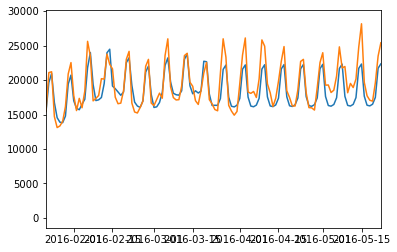

In [195]:
plt.plot(fit)
plt.plot(df6.date, df6.FOODS_3)
plt.xlim('2016-01-22', '2016-05-22')